In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_dataloader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_dataloader(path, train_config)

Save data to ./data/celebaA_data.pkl


0


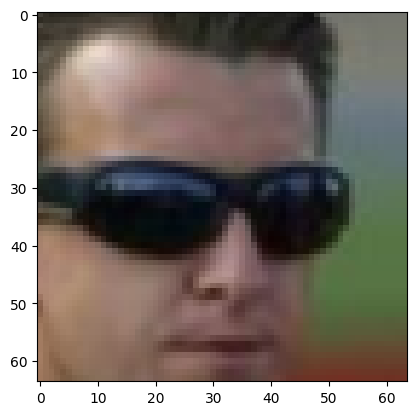

In [4]:
# Plot an image from train_loader
import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
found = False
while not found:
    images, labels = next(iter(train_loader))
    labels = labels.numpy()
    for i in range(len(labels)):
        if labels[i] == 0:
            print(labels[i])
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            plt.show()
            found = True
            break


In [5]:
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18
from examples.mia.celebA_HQ.utils.celeb_hq_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

# Create the model
model = ResNet18(num_classes=num_classes)

# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)



500


Training Progress: 100%|██████████| 30/30 [03:59<00:00,  7.98s/it]


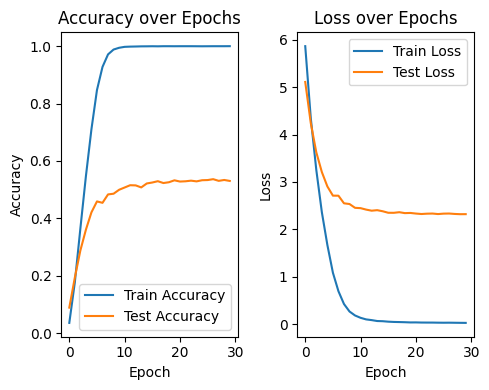

In [6]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Data:
### Pseudo labels -> Top n-selection (test data on target)

### Train:
### GAN (with pseudo labels) - This goes under @prepare_attack

### Test:
### Generate a 'fake' image from generator with target label (a class), run this fake image through the target model to get Loss_inv w.r.t target label. Do this in a loop - This goes under @run_attack


In [7]:
# Auxiliary loader

from examples.minv.celebA.utils.celebA_data import get_celebA_auxloader

aux_loader = get_celebA_auxloader(path, train_config)



Load data from ./data/celebaA_aux_data.pkl


In [ ]:
# Top-n-selection

import torch
from torch.nn import functional as F
import numpy as np

# Get the prediction confidence of each image in aux_loader using the target model
# For each image in aux_loader, we expect a vector of length #classes with the confidence of the model
# that the image belongs to each class
def get_prediction_confidence(model, aux_loader):
    model.eval()
    all_confidences = []
    for images, labels in aux_loader:
        with torch.no_grad():
            outputs = model(images)
            confidences = F.softmax(outputs, dim=1)
            all_confidences.append(confidences)
    return torch.cat(all_confidences)

confs = get_prediction_confidence(model, aux_loader)


[(2387, 0.7095228433609009), (1259, 0.6871603727340698), (791, 0.5730782151222229), (5887, 0.5627214312553406), (2907, 0.5328734517097473), (2265, 0.48797422647476196), (1960, 0.38215577602386475), (919, 0.36410897970199585), (5458, 0.3572092354297638), (9630, 0.28856930136680603)]


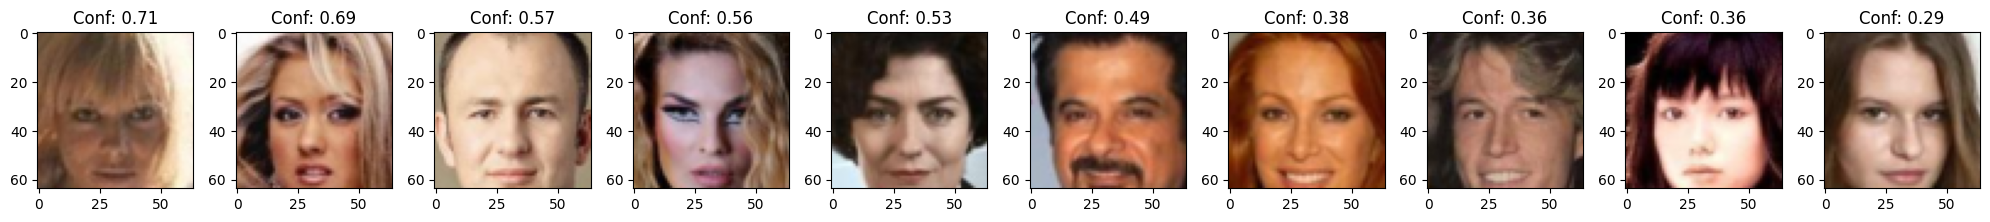

In [87]:
pseudo_labels = torch.max(confs, dim=1)
#print(pseudo_labels)

#empty array of size 500
pseudo_map = [[] for _ in range(num_classes)]

for i, (conf, label) in enumerate(zip(pseudo_labels[0], pseudo_labels[1])):
    pseudo_map[label.item()].append((i, conf.item()))

# Sort pseudo_map by confidence descending
for i in range(num_classes):
    pseudo_map[i] = sorted(pseudo_map[i], key=lambda x: x[1], reverse=True)

# keep only the top n entries in each element of pseudo_map
n = 10
pseudo_map = [pseudo_map[i][:n] for i in range(num_classes)]

print(pseudo_map[0])

# Plot images with their pseudo labels for class 0
plt.figure(figsize=(20, 10))
for i, (idx, conf) in enumerate(pseudo_map[0]):
    plt.subplot(1, n, i + 1)
    plt.imshow(np.transpose(aux_loader.dataset[idx][0], (1, 2, 0)))
    plt.title(f'Conf: {conf:.2f}')
plt.tight_layout()
plt.show()

In [88]:
# save images with pseudo labels into subfolders
import os
from PIL import Image

# Create a directory to store the pseudo-labeled images
pseudo_dir = os.path.join(data_folder, 'pseudo')
os.makedirs(pseudo_dir, exist_ok=True)

# Create subdirectories for each class
for i in range(num_classes):
    os.makedirs(os.path.join(pseudo_dir, str(i)), exist_ok=True)

# Copy the images to the corresponding subdirectories
for i in range(num_classes):
    for idx, _ in pseudo_map[i]:
        img, _ = aux_loader.dataset[idx]
        # convert tensor to PIL image
        img = img.permute(1, 2, 0).numpy()
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(os.path.join(pseudo_dir, str(i), f'{idx}.png'))
        
        

In [ ]:
# GAN training
from examples.minv.celebA.utils.generator import ResNetGenerator
from examples.minv.celebA.utils.discriminator import SNResNetProjectionDiscriminator
import examples.minv.celebA.utils.losses as losses 
import kornia

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the generator and discriminator
gen = ResNetGenerator(num_classes=num_classes).to(device)
dis = SNResNetProjectionDiscriminator(num_classes=num_classes).to(device)

# Load optimizers
opt_gen = torch.optim.Adam(gen.parameters(), 0.0002, (0.0, 0.9))
opt_dis = torch.optim.Adam(dis.parameters(), 0.0002, (0.0, 0.9))

# Adversarial losses
gen_criterion = losses.GenLoss(loss_type='hinge', is_relativistic=False)
dis_criterion = losses.DisLoss(loss_type='hinge', is_relativistic=False)

# Augmentations for generated images
aug_list = kornia.augmentation.container.ImageSequential(
        kornia.augmentation.RandomResizedCrop((64, 64), scale=(0.8, 1.0), ratio=(1.0, 1.0)),
        kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, p=0.5),
        kornia.augmentation.RandomHorizontalFlip(),
        kornia.augmentation.RandomRotation(5),
    )

In [96]:
# Training loop
n_iter = 1000
n_dis = 5
alpha = 0.2

model.to(device)

def sample_from_generator(gen, n_classes, batch_size, device):
    """Sample random z and y from the generator"""
    
    z = torch.empty(batch_size, 128, device=device).normal_()
    y = torch.randint(0, n_classes, (batch_size,)).to(device)
    return gen(z, y), y, z


# Training loop
for i in range(n_iter):
    _l_g = .0
    cumulative_inv_loss = 0.
    cumulative_loss_dis = .0

    cumulative_target_acc = .0
    target_correct = 0
    count = 0
    for j in range(n_dis):
        if j == 0:
            fake, fake_labels, _ = sample_from_generator(gen, num_classes, 64, device)
            fake_aug = aug_list(fake)
            dis_fake = dis(fake_aug, fake_labels)

            inv_loss = losses.max_margin_loss(model(fake_aug), fake_labels)

            dis_real = None

            loss_gen = gen_criterion(dis_fake, dis_real)
            loss_all = loss_gen + inv_loss*alpha

            gen.zero_grad()
            loss_all.backward()
            opt_gen.step()
            _l_g += loss_gen.item()
            cumulative_inv_loss += inv_loss.item()

        fake, fake_labels, _ = sample_from_generator(gen, num_classes, 64, device)

        real, real_labels = next(iter(aux_loader))
        real, real_labels = real.to(device), real_labels.to(device)

        dis_fake = dis(fake, fake_labels)
        dis_real = dis(real, real_labels)

        loss_dis = dis_criterion(dis_fake, dis_real)

        dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()

        cumulative_loss_dis += loss_dis.item()

    if i % 10 == 0:
        print(f'Iter {i}, Dis Loss: {cumulative_loss_dis / n_dis}, Gen Loss: {_l_g / n_dis}, Inv Loss: {cumulative_inv_loss / n_dis}')


Iter 0, Dis Loss: 0.0, Gen Loss: -0.32301523685455324, Inv Loss: 0.7137813091278076
Iter 10, Dis Loss: 0.0, Gen Loss: -0.2927232265472412, Inv Loss: 0.7554747581481933
Iter 20, Dis Loss: 0.0, Gen Loss: -0.3608985662460327, Inv Loss: 0.6039327144622803
Iter 30, Dis Loss: 0.0, Gen Loss: -0.3022636651992798, Inv Loss: 0.4966596126556396
Iter 40, Dis Loss: 0.0, Gen Loss: -0.333603048324585, Inv Loss: 0.6413415431976318
Iter 50, Dis Loss: 0.0, Gen Loss: -0.2437082290649414, Inv Loss: 0.46303548812866213
Iter 60, Dis Loss: 0.0, Gen Loss: -0.222767972946167, Inv Loss: 0.4609210014343262
Iter 70, Dis Loss: 0.0, Gen Loss: -0.16676476001739501, Inv Loss: 0.4813338279724121
Iter 80, Dis Loss: 0.0, Gen Loss: -0.21969397068023683, Inv Loss: 0.4720305442810059
Iter 90, Dis Loss: 0.06724620088934899, Gen Loss: -0.20216612815856932, Inv Loss: 0.4167777061462402
Iter 100, Dis Loss: 0.0, Gen Loss: -0.16224483251571656, Inv Loss: 0.39958217144012453
Iter 110, Dis Loss: 0.0, Gen Loss: -0.17821071147918702

### Model Inversion Attack on Identifier Model 

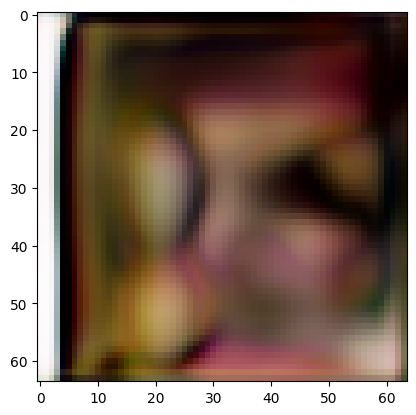

In [105]:
# Save generator and discriminator
torch.save(gen.state_dict(), 'generator.pth')
torch.save(dis.state_dict(), 'discriminator.pth')

# Generate images
gen.eval()

n_images = 1
z = torch.empty(n_images, 128, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device)

with torch.no_grad():
    fake = gen(z, y)
    
plt.imshow(np.transpose(fake[0].cpu().numpy(), (1, 2, 0)))
plt.show()


In [ ]:
# TODO: Write code for our handler
#       Write audit.yaml

# Import input handler
#from examples.mia.celebA_HQ.utils.celeb_hq_input_handler import CelebAHQInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
#leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
#mia_results = leakpro.run_audit(return_results=True)
